# 1. Исследовательский анализ данных

In [25]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [26]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [27]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


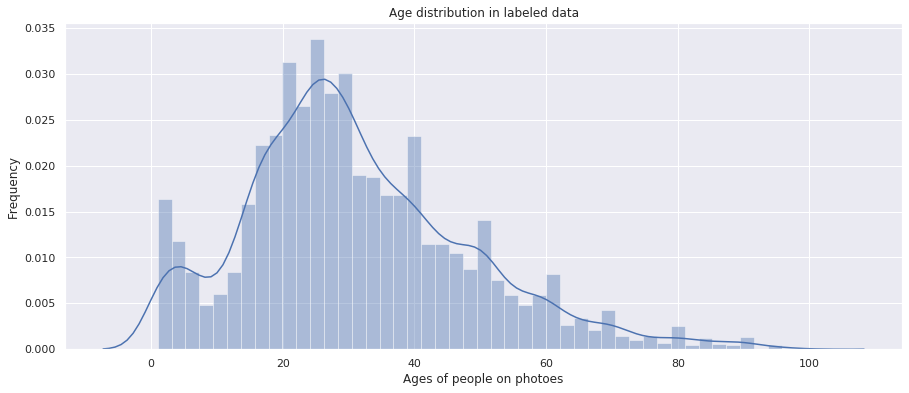

In [30]:
(sns.distplot(a=labels['real_age'], label="age distribution", kde=True)
    .set(title='Age distribution in labeled data', 
         xlabel='Ages of people on photoes', 
         ylabel='Frequency'))

sns.set(rc={'figure.figsize':(15,6)})

In [31]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [32]:
features, target = next(train_gen_flow)

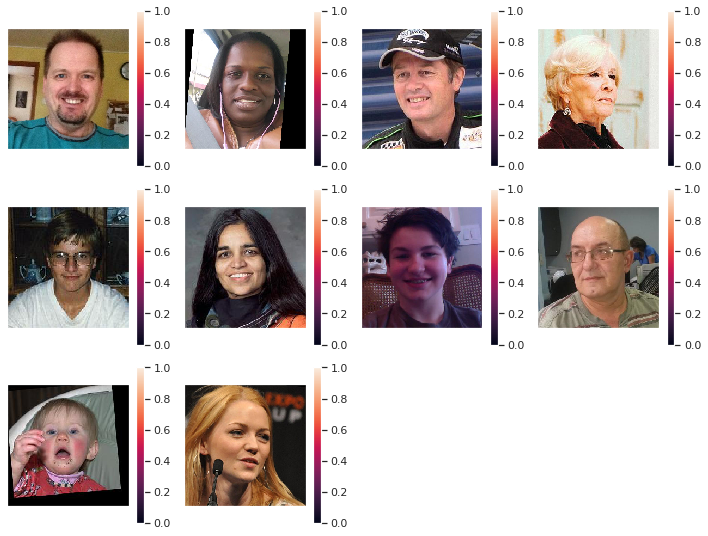

In [33]:
fig = plt.figure(figsize=(10,10))

for i in range(10):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.colorbar()

# 2. Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255)
  
    train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory= path + 'final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='training',
    seed=12345)
       
    return train_datagen_flow 

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')

    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)   

    test_datagen_flow = test_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=path + 'final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='validation',
    seed=12345)
  
    return test_datagen_flow

def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
 
    backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='imagenet', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))  
  
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

    return model

def train_model(model, train_datagen_flow, test_datagen_flow, batch_size=32, epochs=5,
               steps_per_epoch=None, validation_steps=None):
    
    model.fit(train_datagen_flow, validation_data=test_datagen_flow, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, verbose=2, epochs=epochs)

    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/5
2021-02-02 15:07:48.903570: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-02-02 15:07:49.240051: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 50s - loss: 264.1116 - mae: 11.5038 - val_loss: 777.7883 - val_mae: 22.9701
Epoch 2/5
178/178 - 41s - loss: 66.8082 - mae: 6.1916 - val_loss: 654.5996 - val_mae: 20.5850
Epoch 3/5
178/178 - 40s - loss: 31.6730 - mae: 4.3194 - val_loss: 322.1146 - val_mae: 13.2943
Epoch 4/5
178/178 - 41s - loss: 19.6000 - mae: 3.4290 - val_loss: 123.5042 - val_mae: 8.2728
Epoch 5/5
178/178 - 41s - loss: 15.2582 - mae: 2.9978 - val_loss: 72.1565 - val_mae: 6.4669
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 72.1565 - mae: 6.4669
Test MAE: 6.4669

```

# 3. Анализ обученной модели

Нейронная сеть архитектуры ResNet50 была обучена на базе размеченных данных с изображениями лиц людей и указаниями возраста. Ошибка обучения MAE составляет 6.46 лет.